# Recommendations with IBM (Submit Version)

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [797]:
import random
from collections import Counter
from pprint import pp
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [798]:
median_val = df.groupby('email').size().sort_values(ascending=True).median()
max_views_by_user = df.groupby('email').size().sort_values(ascending=False).head(1).values[0]

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [799]:
# Find and explore duplicate articles

dups = df_content.groupby('article_id').size().sort_values(ascending=False) # duplicates of article id
dups_idx = dups[dups > 1].index # duplicates index

df_content[df_content['article_id'].isin(dups_idx)].sort_values(by='article_id') # retrieve duplicated content

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [800]:
# Remove any rows that have the same article_id - only keep the first

df_content = df_content.drop_duplicates('article_id', keep='first')

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [801]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0] # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [802]:
most_viewed_ds = df.groupby('article_id').size().sort_values(ascending=False).head(1)

# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(most_viewed_ds.index[0])

# The most viewed article in the dataset was viewed how many times?
max_views = most_viewed_ds.values[0]

In [803]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [804]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


---

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [805]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_ids_ds = df.groupby('article_id').size().sort_values(ascending=False).head(n)
    ids = article_ids_ds.index
    
    top_articles = []
    for i in ids:
        top_articles.append(df[df['article_id'] == i].head(1).title.values[0])
    
    
    
    return top_articles # Return the top article titles from df (not df_content)


def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles_ids - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    article_ids_ds = df.groupby('article_id').size().sort_values(ascending=False).head(n)
    ids = article_ids_ds.index
    top_articles_ids = list(ids)
 
    return top_articles_ids # Return the top article ids

In [806]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [807]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


---

### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [808]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    df_user_item = df.copy()
    
    # Fill in the function here
    df_user_item['title'] = 1
    df_user_item = df_user_item[['user_id', 'article_id', 'title']]
    
    user_item = pd.pivot_table(df_user_item, index='user_id', columns='article_id', values='title', fill_value=0)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [809]:
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [810]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [811]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    user_ids_all = user_item.index
    
    # a dictionary holds [user id : similarity] value pairs
    dot_product_dict = {}

    # compute similarity of each user to the provided user
    for i in user_ids_all:
        dot_product = np.dot(user_item.loc[user_id:user_id,:], user_item.loc[i:i,:].transpose())
        dot_product_dict[i] = dot_product[0][0]
        
    # sort by highest (most similar), also drop against self    
    ds = pd.Series(dot_product_dict.values(), index=dot_product_dict.keys()).drop(index=user_id).sort_values(ascending=False)
    
    # extract only index as list of ids. 
    most_similar_users = list(ds.index)
       
    return most_similar_users # return a list of the users in order from most to least similar

In [812]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [813]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    article_names = []
    
    for i in article_ids:
        
        # print(i)

        name = df[df.article_id == i].title.head(1).values[0]

        article_names.append(name)
    
    return article_names # Return the article names associated with list of article ids



def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    
    
    article_ids = list(user_item.loc[user_id][user_item.loc[user_id] > 0].index)
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names



def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    
    # get all similar user ids for the targeted user
    similar_uids = find_similar_users(user_id)


    # get all article ids of the targeted user
    article_ids_target_user = get_user_articles(user_id)[0]
    # print(f"[article_ids_target_user]:\n {article_ids_target_user} \n")

    
    # a list contain unseen articles to recommend
    recs = []

    for uid in similar_uids:

        # print(f"\n\n\n[number of recs]: {len(recs)}\n")
        if len(recs) == m:
            # print(f"Number of recs reaches threadhold. Enough. Stop")
            break


        #print(f"[similar user id]: {uid}")

        # get this uid's article ids, and arbitrarily shuffle
        article_ids_similar_user = get_user_articles(uid)[0]

        # compute the differences of articles seen between the this user and targeted user
        # subtraction's order matters
        set_diff = list(set(article_ids_similar_user) - set(article_ids_target_user))
        # print(f"[set_diff]:\n {set_diff} \n")
        
        # make a shuffle for arbitraily chocies from the diff set
        random.shuffle(set_diff)

        # add the differences of article ids to recs [], append only unique (no duplicate)
        for i in set_diff:
            if i not in recs and len(recs) < m:
                recs.append(i)
                # print(f"[id] {i} appended")

    return recs # return your recommendations for this user_id 

In [814]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['perform sentiment analysis with lstms, using tensorflow',
 'why even a moth’s brain is smarter than an ai',
 '54174    detect potentially malfunctioning sensors in r...\nName: title, dtype: object',
 'leverage python, scikit, and text classification for behavioral profiling',
 'machine learning and the science of choosing',
 'times world university ranking analysis',
 'data visualization playbook: telling the data story',
 'using brunel in ipython/jupyter notebooks',
 'awesome deep learning papers',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object']

In [815]:
# According to dataset, df and df_content, article id are all actually numeric. 

print(df.article_id.dtype)
print(df_content.article_id.dtype)

float64
int64


In [816]:
# Test your functions here. 
# I use numeric id instead of string id for article id, since they are actually all numeric.
# It makes sense to make it consistent numeric over this notebook

assert set(get_article_names([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320.0, 232.0, 844.0])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320.0, 232.0, 844.0])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024.0, 1176.0, 1305.0, 1314.0, 1422.0, 1427.0])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [817]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    # get all neighbors ids
    nbh_ids = find_similar_users(user_id)
    
    
    # assemble a data matrix
    data_matrix = np.array([
    [
        x, # neighbor id
        np.dot(user_item.loc[user_id:user_id,:], user_item.loc[x:x,:].transpose())[0][0], # similarity score
        df[df.user_id == x].shape[0] # number of content interaction
    ] for x in nbh_ids])
    
    # make a dataframe
    neighbors_df = pd.DataFrame(data=data_matrix, 
                                columns=['neighbor_id', 'similarity', 'num_interactions'], 
                                index=data_matrix[:,0]).sort_values(by=['similarity', 'num_interactions'],
                                                                    ascending=[False, False])
    
    
    
    return neighbors_df # Return the dataframe specified in the doc_string




def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    
    # get all similar user ids for the targeted user
    # fetch with the 'neighbors_df'
    similar_uids = list(get_top_sorted_users(user_id).index)
    #print(f"[similar_uids]: \n{similar_uids}")


    # get all article ids of the targeted user
    article_ids_target_user = get_user_articles(user_id)[0]
    # print(f"[article_ids_target_user]:\n {article_ids_target_user} \n")

    
    # a list contain unseen articles to recommend
    recs = []

    for uid in similar_uids:

        # print(f"\n\n\n[number of recs]: {len(recs)}\n")
        if len(recs) == m:
            #print(f"Number of recs reaches threadhold {m}. Enough. Stop")
            break


        #print(f"[similar user id]: {uid}")

        # get this uid's article ids, and arbitrarily shuffle
        article_ids_similar_user = get_user_articles(uid)[0]

        # compute the differences of articles seen between the this user and targeted user
        # subtraction's order matters
        set_diff = list(set(article_ids_similar_user) - set(article_ids_target_user))
        #print(f"[set_diff before sort]:\n {set_diff} \n")
        
        # Sort the set. Determine with highest total interactions metric 
        set_diff = list(df[df.article_id.isin(set_diff)]['article_id'].value_counts().index)
        #print(f"[set_diff after sort]:\n {set_diff} \n")

        # add the differences of article ids to recs [], append only unique (no duplicate)
        for i in set_diff:
            if i not in recs and len(recs) < m:
                recs.append(i)
                #print(f"[id] {i} appended")
    
    
    
    
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [818]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [819]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [820]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Answer** 

For new users, code start problem, we can use knowledge base approach, pulling most-interacted (viewed) content and trending content. 
Since the dataset has no timestamp attribute, we might draw the most-interacted content.

In [821]:
new_user = 0.0

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 


new_user_recs = get_top_article_ids(10, df) # Your recommendations here

In [822]:
assert set(new_user_recs) == set([1314.0, 1429.0, 1293.0, 1427.0, 1162.0, 1364.0, 1304.0, 1170.0, 1431.0,
                                  1330.0]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


---

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [823]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


from nltk.util import bigrams
from nltk.util import ngrams
from nltk.lm.preprocessing import flatten

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Constants and Reusable objects for tokenization
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

# Soft copy a article content dataframe for NLP processing.
df_nlp = df_content.copy()

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [824]:
# Tokenization helper

def tokenize(text):
    '''
    private tokenizer to transform each text.
    As a NLP helper function including following tasks:
    - Replace URLs
    - Normalize text
    - Remove punctuation
    - Tokenize words
    - Remove stop words
    - Legmmatize words
    :param text: A message text.
    :return: cleaned tokens extracted from original message text.
    '''

    # print(f"original text: \n {text}")

    # replace urls
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())

    # tokenize text
    tokens = word_tokenize(text)

    # lemmatize and remove stop words
    tokens = [lemmatizer.lemmatize(word).strip() for word in tokens if word not in stop_words]

    # in case after normalize/lemmatize, if there is no words, make a dummy element. otherwise follwing transformation
    # may breaks
    if len(tokens) < 1:
        tokens = ['none']

    # print(f"tokens: \n {tokens} \n\n")
    return tokens

In [825]:
# Do some wrangling, cleaning to the df_nlp dataset.


# Found index and article id mismatched. 
# Update index with article to make it consistent and eaiser to process with.
df_nlp.index = df_nlp.article_id


# Clean empty / missing page body and desc content. Update the empty (NaN) with 'empty' placeholder
df_nlp.loc[df_nlp[df_nlp.doc_body.isnull()].index, 'doc_body'] = 'empty'
df_nlp.loc[df_nlp[df_nlp.doc_description.isnull()].index, 'doc_description'] = 'empty'



In [826]:
# Internal private similarity function of body, title, desc respectly
# These internal functions will be called by similarity overall function (a weighed sum of all similarity).



def _compute_article_body_similarity(article_id_1, article_id_2, data=df_nlp):
    # Compute the consine similarity based on tfidf of body content
    # This is a private helper function that is used by overall similarity function.
    

    doc_a = ' '.join(tokenize(data.loc[article_id_1].doc_body))
    doc_b = ' '.join(tokenize(data.loc[article_id_2].doc_body))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examinate details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]



def _compute_article_title_similarity(article_id_1, article_id_2, data=df_nlp):
    # Compute the consine similarity based on tfidf of title (doc_full_name)
    # think of title tag for seo pagerank
    
    # This is a private helper function that is used by overall similarity function.
    

    doc_a = ' '.join(tokenize(data.loc[article_id_1].doc_full_name))
    doc_b = ' '.join(tokenize(data.loc[article_id_2].doc_full_name))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examinate details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]



def _compute_article_desc_similarity(article_id_1, article_id_2, data=df_nlp):
    # Compute the consine similarity based on tfidf of desc content (doc_description)
    # think of desc tag for seo pagerank
    
    # This is a private helper function that is used by overall similarity function.
    

    doc_a = ' '.join(tokenize(data.loc[article_id_1].doc_description))
    doc_b = ' '.join(tokenize(data.loc[article_id_2].doc_description))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examing details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]

In [827]:
def compute_article_similarity(article_id_1, article_id_2):
    """
    Cosine similarty of overall content details, 
    in consideration of: similarity_title, similarity_body, similarity_desc
    """
    
    # calculate similary for body, title, desc, then combine a single value.
    # think about how google weight title,desc,body. Title tag is very heavy. SEO-wised
    # so having 3 consine similarity values, then do a normailized one. 
    # what's the formular? think of a course, assignments weight x, final exam weight y,
    # then what's total grade.
    # https://www.indeed.com/career-advice/career-development/how-to-calculate-weighted-average
    
    similarity_title = _compute_article_title_similarity(article_id_1,article_id_2)
    similarity_body = _compute_article_body_similarity(article_id_1,article_id_2)
    similarity_desc = _compute_article_desc_similarity(article_id_1,article_id_2)
    
    # a weighted sum caluculation for final score
    # I give title 0.5 weight, body 0.4 weight, desc 0.1 weight. (adjust if necessary)
    
    overall = similarity_title * 0.5 + similarity_body * 0.4 + similarity_desc * 0.1
    
    return overall

In [828]:
# Spot Check:

compute_article_similarity(55, 50)

0.07122043497708203

Find similar articles for a given article.

This only works on the df_content/df_nlp dataset. 

Use full details of an article. (title, desc, body), this info only available in the df_content/df_nlp dataset
Calculate in real-time. It might take some seconds. 
(Because it loops to all articles against the targeted article, use cosine similarity, not dot product.)
For articles not in the df_content/df_nlp dataset, another 

method is suitable lookup_similar_title_articles(), which checks only on the title. 

In [829]:
# Find similar articles for a given article based on content similarity.(overall of title+desc+body)
# This only works on the df_content/df_nlp dataset. 
# Use full details of an article. (title, desc, body), this info only available in the df_content/df_nlp dataset
# Calculate in real-time. It might take some seconds. 
# (since it loops to all articles against the targeted article, use cosine similarity, not dot product.)
# For articles not in the df_content/df_nlp dataset, another 
# method is suitable lookup_similar_title_articles(), which checks only on the title. 


def find_similar_content_articles(article_id, data=df_nlp):
    
    article_ids_all = data.index
    similarity_dict = {}
    
    for i in article_ids_all:
        # print(f"\n[i]: {i}")
        
        if i == article_id:
            continue

        similarity_score = compute_article_similarity(article_id,i)
        similarity_dict[i] = similarity_score
        # print(f"[similarity_score]: {similarity_score}")
    
    
    similarity_ds = pd.Series(data=similarity_dict.values(), 
                           index=similarity_dict.keys()).sort_values(ascending=False).index
    
    return list(similarity_ds)

In [830]:
# Spot Check: 
# Articles that relevant to article id 420, based on content details similarity (title, desc, body)
# Calculate in real time, it might take some seconds
# (Because it loops to all articles against the targeted article, use language consine similarity not dot product.)
start = time.time()
relevant_content_articles_for_420th = find_similar_content_articles(420)
end = time.time()

print(f"{(end - start) / 60} seconds")
print(relevant_content_articles_for_420th[:20])

0.34101983308792116 seconds
[389, 993, 949, 592, 714, 117, 678, 942, 231, 925, 15, 463, 353, 835, 907, 284, 977, 600, 595, 997]


In [831]:
# Spot Check:
# Checking relavancy. They are ordered by relavancy. 

df_nlp.iloc[relevant_content_articles_for_420th].head(20)[['doc_full_name','doc_description','doc_body']]

# Looks like related to 'Apache Spark'

,doc_full_name,doc_description,doc_body
article_id,,,
389,Apache Spark™ 2.0: Impressive Improvements to ...,What a difference a version number makes! With...,* Home\r\n * Community\r\n * Projects\r\n * Bl...
993,Configuring the Apache Spark SQL Context,The Apache Spark website documents the propert...,* Home\r\n * Community\r\n * Projects\r\n * Bl...
949,Apache Spark SQL Analyzer Resolves Order-by Co...,The Apache Spark SQL component has several sub...,* Home\r\n * Community\r\n * Projects\r\n * Bl...
592,Apache Spark Analytics,Combine Apache® Spark™ with other cloud servic...,APACHE SPARK ANALYTICSCombine Apache® Spark™ w...
714,A Survey of Books about Apache Spark™,From the big crop of books about Apache Spark™...,* Home\r\n * Community\r\n * Projects\r\n * Bl...
117,Apache Spark™ 2.0: Migrating Applications,This post provides a brief summary of sample c...,* Home\r\n * Community\r\n * Projects\r\n * Bl...
678,Spark SQL - Rapid Performance Evolution,Spark SQL Version 1.6 runs queries faster! Tha...,{ spark .tc } * Community\r\n * Projects\r\n *...
942,"Interview with Sean Li, New Apache Spark™ Comm...",Sean looks back on his first encounter with Sp...,* Home\r\n * Community\r\n * Projects\r\n * Bl...
231,Speed your SQL Queries with Spark SQL,Get faster queries and write less code too. Le...,Skip to main content IBM developerWorks / Deve...


### Thoughs

The above find_similar_content_articles() work well. However, it is calculating on the fly, could take time to load. 

Such real-time calculating is too expensive in terms of user experience. (Waited xx seconds for similar articles)

To improve the experience, we can pre-calculate or cache the cosine similarity scores.

So make an article_article_similary data frame for lookup. (the content-content recs). 

(people who view X article also might be interested in Y article based on the relevancy of article_article NLP cosine similarity.)

#### Approach

Make a dataframe, store article-article-similarity. (Based on the df_nlp dataframe, the cleaned df_content)

In [832]:
# Make a article_article dummy dataframe based on shape of df_nlp

article_article = pd.DataFrame(
    data=np.zeros((len(df_nlp.index), len(df_nlp.index))),
    index=df_nlp.index,
    columns=df_nlp.index
)

article_article.head()

article_id,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
article_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [833]:
# Compute article_article cosine similarity for each article, and update to the article_article dataframe

# ATTENTION: THE ITERATION TAKES HOURS to finish. 1050 x 1050 instances. 

def compute_and_update_similarity():
    
    start = time.time()


    # Number of articles
    len_articles = article_article.shape[0]

    # List of index of articles
    idx_articles = list(article_article.index)


    # Loop thru each article: for each row, loop each columns. 
    for i in idx_articles:
        print(f"Processing row {i} of {len_articles-1}.")

        for j in idx_articles:
            article_article.loc[i, j] = compute_article_similarity(i, j)


    end = time.time()
    print(f"{(end - start) / 60} seconds")
    


#### Uncomment the below cell ONLY if want to run the compute and update again. (Warning: took hours)

Basically you don't need to do so, as I have already done it and exported to pkl.
(**It took 8 hours**)

Ready to use. You can download from this link:

https://www.dropbox.com/s/oogukiggii75ot3/article_article_similarity_df.pkl

Just load it and use it.

In [834]:
# Check info above. Uncomment only if necessary

# compute_and_update_similarity()
# article_article.to_pickle('article_article_similarity_df.pkl')

In [835]:
# Load from pre-calculated pkl. 

article_article = pd.read_pickle('article_article_similarity_df.pkl')


# All calculated and cached cosine similarity score for every article. Ready to use.
article_article.head()

article_id,0,1,2,3,4,5,6,7,8,9,...,1041,1042,1043,1044,1045,1046,1047,1048,1049,1050
article_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.032471,0.072460,0.020439,0.259333,0.033410,0.016156,0.051355,0.046419,0.047824,...,0.063201,0.051671,0.143709,0.020163,0.010646,0.003492,0.004095,0.028436,0.000000,0.078722
1,0.032471,1.000000,0.186967,0.028671,0.093232,0.098205,0.035012,0.155317,0.206362,0.103742,...,0.104562,0.152361,0.093032,0.030101,0.082490,0.014128,0.019350,0.056505,0.010927,0.090637
2,0.072460,0.186967,1.000000,0.053018,0.172458,0.106455,0.041646,0.204603,0.339824,0.153497,...,0.149979,0.208527,0.139453,0.036274,0.009098,0.009416,0.013930,0.104403,0.018914,0.160396
3,0.020439,0.028671,0.053018,1.000000,0.027609,0.037732,0.084109,0.048761,0.031276,0.049991,...,0.027299,0.026927,0.033499,0.010938,0.036107,0.012851,0.011922,0.010652,0.009425,0.036531
4,0.259333,0.093232,0.172458,0.027609,1.000000,0.095990,0.026990,0.154261,0.135846,0.152328,...,0.122135,0.141956,0.137278,0.024670,0.007071,0.006955,0.003037,0.038724,0.072108,0.138237


In [836]:
# Instead of finding in real time calculation with find_similar_content_articles(),
# this is another approach that uses a lookup from pre-calculated
# article_article df. It saves time for user.

def lookup_similar_content_articles(article_id, data=article_article, n=20):
    """
    NOTE THAT: the cosine similarity score is based on content: title + desc + body, 
    therefore only ids are in df_content are available to work with this method. 
    Otherwise, use lookup_similar_title_articles()
    
    input: n - number of top similar to return
    
    """
    
    

    if article_id in article_article.index.values:

        ids = list(
            data.loc[article_id][data.loc[article_id].index != article_id].sort_values(ascending=False).head(n).index)
        names = list(df_nlp.loc[ids].doc_full_name.values)

    else:
        # print(f"Article {article_id} is not in df_content.")
        # print(f"We are unable to compute overall content similarity for it.")
        # print(f"Alternatively, you might try lookup_similar_title_articles() which is based on title relevancy.")
        ids = []
        names = []

    return ids, names


In [837]:
# Spot Check:
# Lookup most relevant articles for 455th article

relevant_for_455th_article = lookup_similar_content_articles(455, n=30)

print(relevant_for_455th_article[0])
relevant_for_455th_article[1]

# Revealing that they are about on 'machine learning'.

[800, 1035, 313, 805, 444, 721, 260, 967, 122, 96, 384, 809, 124, 723, 234, 892, 54, 253, 812, 861, 412, 732, 871, 74, 221, 89, 479, 616, 500, 567]


['Machine Learning for the Enterprise',
 'Machine Learning for the Enterprise.',
 'What is machine learning?',
 'Machine Learning for everyone',
 'Declarative Machine Learning',
 'The power of machine learning in Spark',
 'The Machine Learning Database',
 'ML Algorithm != Learning Machine',
 'Watson Machine Learning for Developers',
 'Improving quality of life with Spark-empowered machine learning',
 'Continuous Learning on Watson',
 'Use the Machine Learning Library',
 'Python Machine Learning: Scikit-Learn Tutorial',
 '10 Essential Algorithms For Machine Learning Engineers',
 '3 Scenarios for Machine Learning on Multicloud',
 'Breaking the 80/20 rule: How data catalogs transform data scientists’ productivity',
 '8 ways to turn data into value with Apache Spark machine learning',
 'Lifelong (machine) learning: how automation can help your models get smarter over time',
 'Machine Learning Exercises In Python, Part 1',
 'Cleaning the swamp: Turn your data lake into a source of crystal-c

### Side Note on Datasets Inconsistency: 

- df_content (page content of articles)
- df interaction between users and articles)

Since that original df_content only contains articles from [0 - 1050].

However, df (the interaction) dataset shows more unique article ids than those beyond 1050. e,g 11xx, 12xx, 13xx, 14xx.

So these two datasets' articles are not up to date.

The given df_content is 'late' (not catch up), which means that:

**articles in the df (interaction) dataset might not be found in the df_content (content info) dataset.**

Therefore, due to this inconsistency, we will not see content details for some articles mentioned in df (interaction set).

The inconsistency is a limitation of given datasets. 

---

Due to the limitation of inconsistency mentioned above,

Let's create a unified article data frame that **stores every unique article's \[ID\] and \[TITLE\]**.

This dataset serves the purpose of lookup the article's title. (Think of an index of all articles).

Because of the inconsistency, the bottomline: **not every article has body/desc info, but all articles DO have titles**.

The idea is that: **for those articles that cannot do NLP processing on \[TITLE + DESC + BODY\] content, we at least can process NLP on \[TITLE\] for them**.

In [838]:
# Make a all titles dataframe. Store every unique article.
# Schema: article id, article title

def make_titles_df(df=df, df_content=df_content):
    """
    Generate an article index dataframe, from orginal df and df_content
    Only store article id and title for every unique article.
    """
    
    
    unique_ids_in_df = sorted(list(df.article_id.astype('int64').value_counts().index))
    unique_ids_in_df_content = sorted(list(df_content.article_id.astype('int64').value_counts().index))
    
    # ids that are not in df_content, but appear in df
    ids_not_in_df_content = list(set(unique_ids_in_df) - set(unique_ids_in_df_content))
    # print(f"How many?: {len(ids_not_in_df_content)}")
    
    # Subset the diff articles dataframe
    ids_not_in_df_content_float = [float(x) for x in ids_not_in_df_content]
    df_diff = df[df.article_id.isin(ids_not_in_df_content_float)][['article_id', 'title']].drop_duplicates()
    df_diff.article_id = df_diff.article_id.astype('int64')
    df_diff = df_diff.sort_values(by='article_id', ascending=True)
    
    # Subset from df_content
    df_content_titles_subset = df_content[['article_id', 'doc_full_name']]
    df_content_titles_subset.columns = [['article_id', 'title']]
    df_content_titles_subset.index = df_content_titles_subset['article_id'].values.flatten()
    
    # convert to numpy array shape and concatenate
    a = df_diff.to_numpy()
    b = df_content_titles_subset.to_numpy()
    all_titles_np = np.concatenate((a, b))
    
    # make a dataframe
    titles_df = pd.DataFrame(all_titles_np)
    titles_df.columns = ['article_id', 'title']
    titles_df.index = titles_df.article_id
    titles_df = titles_df.sort_index()
    
    return titles_df
    
    
    
# Get titles df
titles_df = make_titles_df()

# Spot check titles df
titles_df

,article_id,title
article_id,,
0,0,Detect Malfunctioning IoT Sensors with Streami...
1,1,Communicating data science: A guide to present...
2,2,"This Week in Data Science (April 18, 2017)"
3,3,DataLayer Conference: Boost the performance of...
4,4,Analyze NY Restaurant data using Spark in DSX
...,...,...
1440,1440,world marriage data
1441,1441,world tourism data by the world tourism organi...
1442,1442,worldwide county and region - national account...


---

### Also Do Similarty Finding Based on Title only 

As we can see, we do have articles that have no content details avaiable.

For these items, we use title to find similarity. 

We can do real-time compuation across all, or like above, we precalculate and cache to title-title dataframe for lookup.

In [839]:
# Find similar articles for a given article based on title only similarity.
# This only works on all articles in df or df_content.
# Use only the TITLE of an article. this info available in both df and df_content
# Calculate in real-time. It might take some seconds. 
# (since it loops to all articles against the targeted article, use cosine similarity, not dot product.)
# For articles also in the df_content/df_nlp dataset, another 
# method is suitable lookup_similar_content_articles(), which checks based on more content information. 


def find_similar_title_articles(article_id, data=titles_df):
    
    """
    Note that it is based on page title only.
    According orginal datasets, every article has title, not not all article have body/desc info.
    
    """
    
    if article_id not in titles_df.index:
        print(f"Article {article_id} is not found.")
        print(f"Please double check the id or try another.")
        result = []
        
    else:
        
        # similarities holder
        similarity_dict = {}

        # loop thru article_id aginst every article

        for i in data.article_id.to_list():
            # print(f"\n[i]: {i}")

            if i == article_id:
                # if against self, skip to next loop
                continue

            # Tokenize self and another. 
            # Rejoin as documents.
            doc_a = ' '.join(tokenize(data.loc[article_id].title))
            doc_b = ' '.join(tokenize(data.loc[i].title))


            # combine to a list of documents
            documents = [doc_a, doc_b]


            # instanciate a scikitlearn tfidf vecorizer
            vectorizer = TfidfVectorizer()

            # fit transform to get a sparse matrix
            matrix = vectorizer.fit_transform(documents)


            # # Uncomment belows to explore details (term features, tfidf values)
            # ====================================
            # term_features =  vectorizer.get_feature_names_out()

            # # convert to readable array 
            # matrix_array = matrix.toarray()

            # # assemble to a dataframe for explor 
            # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
            # ====================================

            similarity_score = cosine_similarity(matrix[:1], matrix[1:])[0][0]
            similarity_dict[i] = similarity_score
            # print(f"[similarity_score]: {similarity_score}")


        similarity_ds = pd.Series(data=similarity_dict.values(), 
                               index=similarity_dict.keys()).sort_values(ascending=False).index

        result = list(similarity_ds)
        
        # Reminder check. 
        if article_id in df_content.article_id.index:
            # print(f"We also have content details (desc, body) information for this article: {article_id}.")
            # print(f"Alternatively, you might want to try find_similar_content_articles() for it.")
            # print(f"It might give you better result, because it checks on title, desc, body")
            pass
    
    return result


In [840]:
# Test Semantic Topics Extracting from given an article id

print(extract_topics_by_title_bigrams(500))

print(extract_topics_by_title_bigrams(55))

print(extract_topics_by_title_bigrams(1400))

print(extract_topics_by_title_bigrams(937))

['Machine Learning', 'Deep Learning']
['Apache Spark', 'Cloud Data']
['Data Science', 'Ibm Data']
['Ibm Watson', 'Watson Data']


In [841]:
# Spot Check:

# Relevant articles for 1420, based on title NLP cosine similarity calculation.

relevant_title_articles_for_1420th = find_similar_title_articles(1420)

titles_df.loc[[1420] + relevant_title_articles_for_1420th].head(20)


,article_id,title
article_id,,
1420,1420,use apache systemml and spark for machine lear...
161,161,Use the Machine Learning Library in Spark
893,893,Use the Machine Learning Library in IBM Analyt...
1172,1172,"apache spark lab, part 3: machine learning"
284,284,Apache Spark 2.0: Machine Learning. Under the ...
112,112,Building Custom Machine Learning Algorithms Wi...
809,809,Use the Machine Learning Library
721,721,The power of machine learning in Spark
313,313,What is machine learning?


---
As we can see, the relevancy of title calculation works fine, it is calculated in real-time. 

It loops thru a targeted article against every article. 

Agian, make a precalcualted title-title dataframe to store all title-title cosine similarity score,
so that we can cache and lookup directly.

In [842]:
# Make a title-title dummy dataframe based on titles_df
title_title = pd.DataFrame(
    data=np.zeros((titles_df.shape[0], titles_df.shape[0])),
    index=titles_df.index,
    columns=titles_df.index
)

title_title.head()

article_id,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
article_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [843]:
# Compute title-title cosine similarity for each article, and update to the title-title dataframe

# ATTENTION: THE ITERATION TAKES HOURS to finish. 


def _compute_title_title_similarity(article_id_1, article_id_2, data=titles_df):
    # Compute the consine similarity based on tfidf of title (doc_full_name)
    # Based on the titles df (union all titles in df and df_content)
    

    doc_a = ' '.join(tokenize(data.loc[article_id_1].title))
    doc_b = ' '.join(tokenize(data.loc[article_id_2].title))
    
    

    # combine to a list of documents
    documents = [doc_a, doc_b]

    
    # instanciate a scikitlearn tfidf vecorizer
    vectorizer = TfidfVectorizer()

    # fit transform to get a sparse matrix
    matrix = vectorizer.fit_transform(documents)


    # # UnComment out belows to examing details (term features, tfidf values)
    # ====================================
    # term_features =  vectorizer.get_feature_names_out()

    # # convert to readable array 
    # matrix_array = matrix.toarray()

    # # assemble to a dataframe for explor 
    # tfidf_dataframe = pd.DataFrame(data=matrix_array, columns=term_features)
    # ====================================


    return cosine_similarity(matrix[:1], matrix[1:])[0][0]



def compute_and_update_title_title_similarity():
    
    """
    Update every cell of title_title dataframe with title_title cosine similarity score.
    """
    
    start = time.time()


    # Number of articles in title_title
    len_articles = title_title.shape[0]


    # List of index of all articles
    idx_articles = list(title_title.index)

    # Last idx for tracking in print
    idx_last = title_title.tail(1).index[0]

    # Loop thru each article: for each row, loop each columns. 
    for i in idx_articles:
        print(f"Processing row {i} of {idx_last}.")

        for j in idx_articles:
            title_title.loc[i, j] = _compute_title_title_similarity(i, j)


    end = time.time()
    print(f"{(end - start) / 60} seconds")

    

Uncomment the below cell ONLY if want to run the compute and update again. (Warning: took time)

Basically you don't need to do so, as I have already done it and exported to pkl. (It took 1 hour)

Ready to use. You can download from this link:

https://www.dropbox.com/s/j74bmaese35i2pz/title_title_similarity_df.pkl

Just load it and use it.

In [844]:
# Check info above. Uncomment only if necessary

# compute_and_update_title_title_similarity()
# title_title.to_pickle('title_title_similarity_df.pkl')

In [845]:
# Load from pre-calculated pkl. 

title_title = pd.read_pickle('title_title_similarity_df.pkl')


# All calculated and cached cosine similarity score for every article. Ready to use.
title_title.head()

article_id,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
article_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,1.000000,0.201993,0.0,0.08458,0.115216,0.0,0.136276,0.260556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.136276,0.069973,0.0,0.0,0.0
2,0.0,0.201993,1.000000,0.0,0.08458,0.115216,0.0,0.136276,0.450176,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.136276,0.069973,0.0,0.0,0.0
3,0.0,0.000000,0.000000,1.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.084580,0.084580,0.0,1.00000,0.105992,0.0,0.125367,0.105992,0.130494,...,0.0,0.0,0.0,0.0,0.0,0.125367,0.064371,0.0,0.0,0.0


In [846]:
# Instead of finding in real time calculation with find_similar_title_articles(),
# this is another approach that uses a lookup from pre-calculated
# title_title df. It saves time for user.

def lookup_similar_title_articles(article_id, data=title_title, n=20):
    """
    NOTE THAT: the cosine similarity score is based on title only.
    
    input: n - number of top similar to return
    
    

    
    """
    
    if article_id in title_title.index.values: 
    
        ids = list(data.loc[article_id][data.loc[article_id].index != article_id].sort_values(ascending=False).head(20).index)
        names = list(titles_df.loc[ids].title.values)
        
    else:
        print(f"[article_id] {article_id} not found in datasets.")
        ids = []
        names = []
        
    
    return ids, names



In [847]:
# Spot Check

lookup_similar_title_articles(437)

([122,
  313,
  1427,
  762,
  254,
  1390,
  655,
  805,
  444,
  800,
  260,
  1035,
  384,
  1001,
  40,
  500,
  893,
  1297,
  390,
  1185],
 ['Watson Machine Learning for Developers',
  'What is machine learning?',
  'use xgboost, scikit-learn & ibm watson machine learning apis',
  'From Machine Learning to Learning Machine (Dinesh Nirmal)',
  'Apple, IBM add machine learning to partnership with Watson-Core ML coupling',
  'style transfer experiments with watson machine learning',
  'Create a project for Watson Machine Learning in DSX',
  'Machine Learning for everyone',
  'Declarative Machine Learning',
  'Machine Learning for the Enterprise',
  'The Machine Learning Database',
  'Machine Learning for the Enterprise.',
  'Continuous Learning on Watson',
  'Get started in Bluemix',
  'Ensemble Learning to Improve Machine Learning Results',
  'The Difference Between AI, Machine Learning, and Deep Learning?',
  'Use the Machine Learning Library in IBM Analytics for Apache Spark',
 

---

In [848]:
# Internal Utility Helper Functions



def _union_list(list_a, list_b):
    """
    Combine two lists. 
    Use Case:
    List that from title similarity, list that from content similarity. 
    Intersection plus each list's unique items.
    Return the blended union result.
    
    
    INPUT: two lists 
    OUTPUT: a union list. (unique of each list plus intersection)
    
    """
    
    
    
    
    intersect = np.intersect1d(list_a, list_b)
    unique_in_a = set(list_a) - set(intersect)
    unique_in_b = set(list_b) - set(intersect)
    
    union = list(set.union(set.union(unique_in_a, unique_in_b), intersect))
    
    # shuffle the list
    random.shuffle(union)

    
    return union




def _get_article_titles(ids, data=titles_df):
    """
    With given article ids (list), return titles as list. 
    Assume that the ids given are valid. 
    This is a helper function, only serves for output title name, which means  
    No Sanity Check Here: the outside is responsible for passing valid ids into here. 
    
    
    INPUT: list of article ids
    OUTPUT: list of article titles
    
    """
    # Input: a list of article ids
    # data: the all article title dataframe
    
    titles = data.loc[ids].title.apply(lambda x: x.title()).values
    result = list(titles)

    return result


----

### Putting All Content-Content together to Make Recs

#### Strategy Explain: 

1. Get relevant articles based on TITLE similarity. (**Guaranteed**. )
2. Get relevant articles based on CONTENT (title + desc + body weighted sum) similarity. (**Not Guaranteed**. Only if an article has details available. )
3. Combine them to a union list. 

Then, look further for an extra layer, to fetch relevant content of its relevant content. 
Think of 'relevant of relevant.' 

4. Add these extra on the union list. 


In [849]:
def make_content_recs(article_id, data=titles_df):
    '''
    Content Based Recommendations. 'Content-Content'.

    Strategy:
    1. Get relevant articles based on TITLE similarity. (Guaranteed. )
    2. Get relevant articles based on CONTENT (title + desc + body weighted sum) similarity.
    (Not Guaranteed. Only if an article has details available. )
    3. Combine them to a union list.
    Then, look further for an extra layer, to fetch relevant content of its relevant content. Think of 'relevant of relevant.'
    4. Add these extra on the union list.

    INPUT: article id
    OUTPUT: tuple of recommendation ids and titles
    '''

    recs_based_on_title = lookup_similar_title_articles(article_id)[0]
    recs_based_on_content = lookup_similar_content_articles(article_id)[0]

    union_recs = _union_list(recs_based_on_title, recs_based_on_content)
    
    # a list holder for second layer recs items
    extra_recs = []

    # If article_id not in df_content, find one from the union_recs list that is in df_content or article_article,
    # so that it can use content similarity score to load extra relevant content.
    if article_id not in article_article.index.values:
        # print(f"{article_id} not in article_article, pulling additional relevant content.")

        # loop thru first layer recs
        for i in union_recs:
            if i in article_article.index.values:
                # find similar base on content similarity score, and slice first 5 instances
                extra = lookup_similar_content_articles(i)[0][:5]
                extra_recs.append(extra)

    extra_recs = np.array(extra_recs).flatten()
    extra_recs = list(np.unique(extra_recs))

    for e in extra_recs:
        if e not in union_recs:
            union_recs.append(e)

    titles = _get_article_titles(union_recs)

    return union_recs, titles

In [850]:
make_content_recs(1427)

([254,
  313,
  260,
  34,
  437,
  762,
  161,
  1390,
  1035,
  1422,
  384,
  124,
  800,
  655,
  893,
  1420,
  805,
  122,
  444,
  809,
  96,
  112,
  250,
  455,
  495,
  511,
  555,
  592,
  595,
  600,
  686,
  721,
  723,
  751,
  793,
  806,
  812,
  907,
  967,
  972,
  1006],
 ['Apple, Ibm Add Machine Learning To Partnership With Watson-Core Ml Coupling',
  'What Is Machine Learning?',
  'The Machine Learning Database',
  'Top 10 Machine Learning Use Cases: Part 1',
  'Ibm Watson Machine Learning: Get Started',
  'From Machine Learning To Learning Machine (Dinesh Nirmal)',
  'Use The Machine Learning Library In Spark',
  'Style Transfer Experiments With Watson Machine Learning',
  'Machine Learning For The Enterprise.',
  'Use R Dataframes & Ibm Watson Natural Language Understanding',
  'Continuous Learning On Watson',
  'Python Machine Learning: Scikit-Learn Tutorial',
  'Machine Learning For The Enterprise',
  'Create A Project For Watson Machine Learning In Dsx',
  'Us

---

### Extracting Semantic Topic(s) from Article

In [851]:
# helper function: get n-grams (two grams here)

# Why 2-grams, not 3-grams or everygram? Because thru experiment, I found 
# 2 grams generalize the meaning well, 
# 3 grams often off the track, every-gram went too verbose and miss out meaning
# It is case by case, however for these articles, 2 grams works well. 


def get_content_bigrams_by_article_id(article_id, data=df_nlp):
    """
    Input an article id, return the bigrams results of its content
    Then Reorder grams By most frequent.
    
    Note that the content is combination string of title, desc, body.
    So assume that the article id is IN df_content, if the artcile is not in, we will
    not be able to get its decs, body content.
    
    
    """
    
    if article_id not in data.index:
        print(f"{article_id} is not found in article content details dataset.")
        print(f"You can try ngrams from title. \nAlternative method: get_title_bigrams_by_article_id()")
        return []
    
    else:
        title = data.loc[article_id].doc_full_name
        desc = data.loc[article_id].doc_description
        body = data.loc[article_id].doc_body

        # a list of tokens
        tokened_text = tokenize(title) + tokenize(desc) + tokenize(body)

        # ngrams 2
        grams = [f"{x[0]} {x[1]}" for x in list(bigrams(tokened_text))]

        # sort with frequency descending
        sorted_grams = [x[0] for x in Counter(grams).most_common()]

        return sorted_grams
    

    

    
def get_title_bigrams_by_article_id(article_id, data=titles_df):
    """
    Input an article id, return the bigrams results of its title
    Then Reorder grams By most frequent.
    
    Note that it is based on page title only.
    According orginal datasets, every article has title, not not all article have body/desc info.
    
    
    """
    if article_id not in data.index:
        print(f"{article_id} is not found in article titles dataset.")
        print(f"We don't have any information for this article. \nPlease check article id again.")
        return []
    
    else:
    
        title = data.loc[article_id].title

        # a list of tokens
        tokened_text = tokenize(title)

        # ngrams 2
        grams = [f"{x[0]} {x[1]}" for x in list(bigrams(tokened_text))]

        # sort with frequency descending
        sorted_grams = [x[0] for x in Counter(grams).most_common()]
        
        # Reminder check
        if article_id in df_content.article_id.index:
            # print(f"We also have content details, e,g desc, body information for this article: {article_id}.")
            # print(f"Alternatively, you might want to try get_content_bigrams_by_article_id() for it.")
            pass
        
        
        return sorted_grams
    

    
def extract_topics_by_title_bigrams(article_id, m=2):
    """
    Extract semantic topic with a given article ID.
    It takes all similar articles into consideration, then output highly possible topics. 
    
    Algorithm Explain:
    1. For this targeted article, we pull out its most similar articles.
    2. Combine them to a list of documents.
    3. Batch process NLP bigrams on each doc.
    4. Find out most frequent terms amount all bigrams. 
    5. Slice first m (e.g 2) terms. 

    INPUT:
    m - threshold of top m to slice from the frequent term counter

    OUTPUT:
    topics - Possible topics.
    """

    # Get relevant articles' ids. (also append self)
    ids = [article_id] + make_content_recs(article_id)[0]

    # Get ngrams for each title, and assemble to documents list.
    documents = [get_title_bigrams_by_article_id(i) for i in ids]

    # Find most common bigrams of all its relevant articles.
    # These bigrams will highly possible be the topics.
    documents_flatten = [item for sublist in documents for item in sublist]

    # most counted terms. Select first m instances.
    topics_counter = Counter(documents_flatten).most_common()[:m]

    # Convert to list.
    topics = [x[0].title() for x in topics_counter]

    return topics

In [852]:
# Spot Check:
# Test Sementic Topics Extracting from given an article id

print(extract_topics_by_title_bigrams(500))
print(extract_topics_by_title_bigrams(55))
print(extract_topics_by_title_bigrams(1400))
print(extract_topics_by_title_bigrams(937))
print(extract_topics_by_title_bigrams(1314))

['Machine Learning', 'Deep Learning']
['Apache Spark', 'Cloud Data']
['Data Science', 'Ibm Data']
['Ibm Watson', 'Watson Data']
['Apache Spark', 'Jupyter Notebook']


---

### Get Insight of Top Semantic Topics within the Raw Dataset.

In [853]:
# Internal Helpler Private Function.
# Get most interacted (popular) articles.

def _get_most_popular_articles(data=df, n=20):
    # input: n - number of top viewed to return
    
    ids = data.groupby('article_id').size().sort_values(ascending=False).head(n).index
    
    return list(ids.values)

In [854]:
# Show Top Sementic Topics (NLP mining)

def show_top_topics():
    """
    A Business intelligence (BI) tool that helps executives, managers and workers make informed business decisions.

    What are the highly possible top semantic topics amount the data.

    No output return. Just print information to console.
    """



    # Checked the top interacted content
    most_popular_list = _get_most_popular_articles()
    print(f"💡 Most popular(interacted) contents:\n")
    print(most_popular_list)
    print('\n' * 3)

    # A list to hold each hot/popular content's topics
    popular_topics_overall = []

    print(f"💡 What are their topics? (Based on NLP mining)\n")

    # Loop thru each popular article, extract its topic and combine them.
    for article_id in most_popular_list:
        article_id = int(article_id)
        topics = extract_topics_by_title_bigrams(article_id)
        print(f"[{article_id}] is about: {topics}")
        popular_topics_overall.append(topics)

    # Sort with most frequent to represent most popular topics
    print('\n' * 3)
    print(f"💡 Based on the most viewed articles (top 20 instances), the top 10 popular topics are:\n")
    most_popular_topics = [x[0] for x in Counter(np.array(popular_topics_overall).flatten()).most_common()[0:10]]

    # Show top topics
    for k, v in enumerate(most_popular_topics):
        print(k + 1, v)

    print('\n' * 3)
    print(f"💡 Thoughts:\n")
    print(
        f"This is valuable because, based on such demand, we can feed more related content in the future. \n"
        f"Also, to serve as a knowledge-based recommendation for brand new users.")


In [855]:
# BI Spot Check

show_top_topics()

💡 Most popular(interacted) contents:

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0, 1436.0, 1271.0, 1398.0, 43.0, 1351.0, 1393.0, 1185.0, 1160.0, 1354.0, 1368.0]




💡 What are their topics? (Based on NLP mining)

[1429] is about: ['Deep Learning', 'Machine Learning']
[1330] is about: ['Cloudant Query', 'Apache Spark']
[1431] is about: ['Watson Data', 'Data Science']
[1427] is about: ['Machine Learning', 'Watson Machine']
[1364] is about: ['Machine Learning', 'Data Science']
[1314] is about: ['Apache Spark', 'Jupyter Notebook']
[1293] is about: ['Data Science', 'Cloudant Query']
[1170] is about: ['Apache Spark', 'Spark Sql']
[1162] is about: ['Machine Learning', 'Jupyter Notebook']
[1304] is about: ['Machine Learning', 'Logistic Regression']
[1436] is about: ['Data Science', 'Ibm Watson']
[1271] is about: ['Making Compose', 'Compose Customer']
[1398] is about: ['Country Statistic', 'Country Population']
[43] is about: ['Deep Learning', 'Data Science']

---

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

### A: As above shown, the content-based recommendation system with the blending of multiple approaches:
- NLP TFIDF cosine similarity computed on the content (Weighted Sum of title, desc, body)
- Due to dataset inconsistency, to overcome it, I also give a 'fallback' for those articles that don't have content details, compute cosine similarity on the title.
- Each similarity score allows the system to compute in real-time or by lookup from precalculate / cache scores.
- The make recs is a blending article title similarity and content similarity strategy.
- In addition, the system extracts highly possible semantic topics for any given article by mining from its neighbors.
- Finally, it has a Business Intelligence tool that shows the insight of top semantic topics. It can guide investors/managers/executives to feed quality information and understand trends, demands.

---
`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.



### A: Recs for Brand New Users

#### Strategy: Content-based + Knowleadge-based Blending 

**Approach:**
1. Pull the most popular content, ranked based. (First layer - most popular items)
2. Pull similar contents of each popular content (Second layer - relevant of popular)
3. Blend them. Make sure the first layer's content shows first (ranked order), followed by the second layer (random shuffle).

In [856]:
# Cold Start recs

def make_recs_for_brand_new_user(threshold_second_layer=5):
    """
    Make recs for brand new user.
    
    Strategy: Content-based + Knowledge-based Blending 

    **Approach:**
    1. Pull the most popular content, ranked based. (First layer - most popular items)
    2. Pull similar contents of each popular content (Second layer - relevant of popular)
    3. Blend them. Make sure the first layer's content shows first (ranked order), 
                    followed by the second layer (random shuffle).

    INPUT:
    threshold_second_layer: How many recs items for each 2nd layer fetch.

    OUTPUT: a tuple of ids and titles
    """

    # Get list of most popular contents
    popular_ids = _get_most_popular_articles(n=10)
    popular_ids = [int(x) for x in popular_ids]

    # List of recs of similar content for popular content. (the 'All 2nd-layer recs')
    recs_for_similar = []

    # We will make sure it has no duplication
    recs_for_similar_no_duplicate = []

    for i in popular_ids:
        # print(i)

        # fetch relevant content for this popular article
        recs_items = make_content_recs(i)[0]

        # random select some from similar
        recs_items = random.sample(recs_items, threshold_second_layer)

        # append to recs_for_similar list
        recs_for_similar.append(recs_items)

    # Flatten the recs_for_similar (All 2nd layer recs), and shuffle it
    recs_for_similar = list(np.array(recs_for_similar).flatten())
    random.shuffle(recs_for_similar)

    # Make sure recs_for_similar has no duplicated content
    for r in recs_for_similar:
        if (r not in recs_for_similar_no_duplicate) and (r not in popular_ids):
            recs_for_similar_no_duplicate.append(r)

    # print(popular_ids)
    # print(recs_for_similar_no_duplicate)

    # Combine popular_ids (ranked-based / knowledge based) + recs_for_similar (content-based)
    # Order Matters: ranked based come first, follow by content-based. (since it is cold start)
    all_recs_ids = popular_ids + recs_for_similar_no_duplicate
    all_recs_titles = _get_article_titles(all_recs_ids)

    return all_recs_ids, all_recs_titles

In [857]:
# make recommendations for a brand new user

recs_for_new_user = make_recs_for_brand_new_user()[1]

print(f"💡 Welcome, @[new user]! Here are some content you might be interested: \n")

for k, v in enumerate(recs_for_new_user):
    print(k+1, v)

💡 Welcome, @[new user]! Here are some content you might be interested: 

1 Use Deep Learning For Image Classification
2 Insights From New York Car Accident Reports
3 Visualize Car Data With Brunel
4 Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis
5 Predicting Churn With The Spss Random Tree Algorithm
6 Healthcare Python Streaming Application Demo
7 Finding Optimal Locations Of New Store Using Decision Optimization
8 Apache Spark Lab, Part 1: Basic Concepts
9 Analyze Energy Consumption In Buildings
10 Gosales Transactions For Logistic Regression Model
11 A Survey Of Books About Apache Spark™
12 Make Machine Learning A Reality For Your Enterprise
13 Top 10 Machine Learning Use Cases: Part 1
14 Cifar-100 - Python Version
15 Predicting Gentrification Using Longitudinal Census Data
16 Intelligent Applications - Apache Spark
17 Recommendation System Algorithms – Stats And Bots
18 Data Tidying In Data Science Experience
19 Create A Project For Watson Machine Learning In Dsx
20 Br

In [858]:
# make a recommendations for a user who only has interacted with article id '1427.0'

print(
    f"💡 \nSince you checked article 1427:\n "
    f"({_get_article_titles([1427])[0]}), \n"
    f"you might also be interested in these:\n")

recs_for_user_1427th_titles = make_content_recs(1427)[1]

for k, v in enumerate(recs_for_user_1427th_titles):
    print(k + 1, v)
    


💡 
Since you checked article 1427:
 (Use Xgboost, Scikit-Learn & Ibm Watson Machine Learning Apis), 
you might also be interested in these:

1 Apple, Ibm Add Machine Learning To Partnership With Watson-Core Ml Coupling
2 Use The Machine Learning Library In Ibm Analytics For Apache Spark
3 Style Transfer Experiments With Watson Machine Learning
4 Continuous Learning On Watson
5 Machine Learning For The Enterprise.
6 From Machine Learning To Learning Machine (Dinesh Nirmal)
7 Create A Project For Watson Machine Learning In Dsx
8 Use The Machine Learning Library
9 What Is Machine Learning?
10 The Machine Learning Database
11 Use Apache Systemml And Spark For Machine Learning
12 Declarative Machine Learning
13 Use The Machine Learning Library In Spark
14 Use R Dataframes & Ibm Watson Natural Language Understanding
15 Ibm Watson Machine Learning: Get Started
16 Python Machine Learning: Scikit-Learn Tutorial
17 Machine Learning For Everyone
18 Watson Machine Learning For Developers
19 Machin

---

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [859]:
# Load the matrix here
# The matrix is generated in Part 3 above, use it directly. 

# quick look at the matrix
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [860]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item) # use the built in to get the three matrices

u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

#### A: 

As the values of user_item matrix are binary. 0, 1. Default value is 0 indicates no interaction. 

And no missing values. So SVD is suitable. If there are missing values, we can approach with FunkSVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

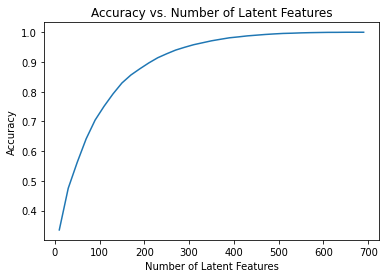

In [861]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [862]:
# Train | Test Spilt

df_train = df.iloc[0:40000,:].copy()
df_test = df.iloc[40000:,:].copy()


df_train.article_id = df_train.article_id.astype(int)
df_test.article_id = df_test.article_id.astype(int)

print("Number of instances for training: ", df_train.shape[0])
print("Number of instances for testing: ", df_test.shape[0])

Number of instances for training:  40000
Number of instances for testing:  5993


In [863]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.to_list()
    test_arts = user_item_test.columns.to_list()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [864]:
# Q: 
# How many users can we make predictions for in the test set?': 
# 
# that means how many intersected users in train that also found in test set.

user_ids_intersected = np.intersect1d(user_item_train.index, user_item_test.index)

number_of_user_ids_intersected = len(user_ids_intersected)
print(number_of_user_ids_intersected)

# Substract the number from number of test. (number of unique users different from train set)
len(test_idx) - number_of_user_ids_intersected

# Users can predict are the intersected / common users in train and test set. 
# (If users that are not in training set, then machine will not have affinity info for them)
# since latent factor applied to users. Since we know these users' affinity, we might know how likely 
# he/she would like to interact each article (even tho he/she not interacted that article before). 

20


662

In [865]:
# Q:
# How many articles can we make predictions for in the test set?
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
# That means, are article ids that in test set, also appear in train set. Any unique article not found in train set.

article_ids_intersected = np.intersect1d(user_item_train.columns, user_item_test.columns)

np.sum(article_ids_intersected != np.array(user_item_test.columns))

# zero. no unique found. Which means, ids in test set are all also there in train set. all movies in test will 
# have its latent factor. 

0

In [866]:
print(user_item_train.shape)
print(user_item_test.shape)

(4487, 714)
(682, 574)


In [867]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
    }

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [868]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [869]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

In [870]:
print(u_train.shape, s_train.shape, vt_train.shape)

print(f"Total users in train set: {u_train.shape[0]}")
print(f"Total articles in train set: {vt_train.shape[0]}")
print(f"Total number of latent factors: {s_train.shape[0]}")

(4487, 4487) (714,) (714, 714)
Total users in train set: 4487
Total articles in train set: 714
Total number of latent factors: 714


In [871]:
from sklearn.metrics import r2_score

#  Rows that match the test set
test_idx = user_item_test.index
row_idxs = user_item_train.index.isin(test_idx)
u_test = u_train[row_idxs, :]


#  Columns that match the test set
test_col = user_item_test.columns
col_idxs = user_item_train.columns.isin(test_col)
vt_test = vt_train[:, col_idxs]

# Test data (reshaping to the subset of those intersected users)
train_idx = user_item_train.index
row_idxs_2 = user_item_test.index.isin(train_idx)
user_item_test_subset = user_item_test.loc[row_idxs_2]



num_latent_feats = np.arange(10,700+10,20)

scores_train = []
scores_test = []


for k in num_latent_feats:
    
    
    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    
    # Take dot product to get prediction
    
    # predictions on train set
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    
    # predictions on test set
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    
    

    # Calculate R2 score with 
    # sklearn.metrics.r2_score(y_true, y_pred)
    
    # R2 score as accuracy for train set. (true of train vs pred of train)
    r2s_train_sets = r2_score(user_item_train, user_item_train_preds)
    
    # R2 score as accuracy for test set. (true ot test vs pred of test)
    r2s_test_sets = r2_score(user_item_test_subset, user_item_test_preds)
    
    # Append each accuracy result
    scores_train.append(r2s_train_sets)
    scores_test.append(r2s_test_sets)
    
    print(r2s_train_sets, r2s_test_sets)

0.007516754093525902 0.6604198054917303
0.05582851571825394 0.6328017631956505
0.11007778268016816 0.6168364553780433
0.16561571815696632 0.5848351225385319
0.21981865806865664 0.5603945375754067
0.27937356264867874 0.5309917623446467
0.3322637852734185 0.5149353611791314
0.3752365658946877 0.5038755724797407
0.4179165888310912 0.49245474398574146
0.46329130485256803 0.48191008966701776
0.5025390623844941 0.4679728074370526
0.5404423050485289 0.46091247367582017
0.5811492088746872 0.4503678193570966
0.6171027979107029 0.4433074855958643
0.643502954189826 0.4378976194671278
0.6678385930007024 0.4309289783521452
0.6982067468163089 0.4309289783521452
0.7221670545560043 0.42744465779465396
0.7470141484284704 0.42744465779465396
0.7799326215735457 0.42396033723716264
0.7999294739708878 0.42396033723716264
0.8196544380706139 0.42396033723716264
0.8360005380978012 0.42396033723716264
0.8582465833381127 0.42396033723716264
0.8778089868944815 0.42396033723716264
0.8927366188987824 0.42396033723

<AxesSubplot:>

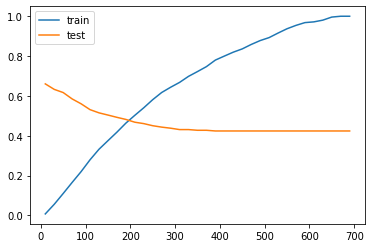

In [872]:
# Plotting

df_scores = pd.DataFrame({
   'train': scores_train,
   'test': scores_test
   }, index=num_latent_feats)

df_scores.plot.line()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

#### Intepreting the Result:
- As we can see, while the k (the number of latent factors) increases, the accuracy improves, the amount of data points benefit the model, the latent factors/affinity gets more accurate.
- In contrast, in the test set predict simulation, accuracy worsens when the number of latent factors increases. Possibly due to a very limited of data points (20 instances only) in the test set. The more latent factors, the more overfitted, making it even less predictable.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 